Imports and load charged hadrons from file:

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

h_container = "efcharged.core"
file = uproot.open("/eos/experiment/fcc/ee/tmp/fcc_python_tools/FCCDelphesOutput_total.root",branches=f"{h_container}*")
tree = file['events']

h = tree.arrays(filter_name=f"{h_container}*",how="zip")

Build $D^0$ candidates:

In [2]:
h[h_container,'p4.p'] = kinematics.calc_p(h,h_container)
p_cut = h[h_container,"p4.p"] > 3.
h = h[p_cut]

pi_cut = abs(h[h_container,"pdgId"]) == abs(lp.pi_plus.pdgid)
h["pi"] = h[h_container][pi_cut]

k_cut = abs(h[h_container,"pdgId"]) == abs(lp.K_plus.pdgid)
h["k"] = h[h_container][k_cut]

D = ak.cartesian({"k": h["k"], "pi": h["pi"]})
D_cut = np.sign(D["k","pdgId"]) != np.sign(D["pi","pdgId"])
D = D[D_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D["mass"] = kinematics.mass_2body(D["k"], D["pi"], PDG_K_m, PDG_pi_m)

PDG_D_m = lp.D_0.mass/1000.
D_cut = abs(D["mass"] - PDG_D_m) < 0.01
D = D[D_cut]

Build $B^\pm \to D^0 \pi^\pm$ candidates, keeping only those where the $K$ from the $D^0$ has the same charge as the $\pi$ produced in the $B^\pm$ decay:

In [8]:
B = ak.cartesian({"D_k": D["k"], "D_pi": D["pi"], "pi": h["pi"]})
B_cut = np.sign(B["D_k","pdgId"]) == np.sign(B["pi","pdgId"])
B = B[B_cut]
B["mass"] = kinematics.mass_3body(B["D_k"], B["D_pi"], B["pi"], PDG_K_m, PDG_pi_m, PDG_pi_m)

Keep $B^\pm$ candidates within a certain mass range and plot:

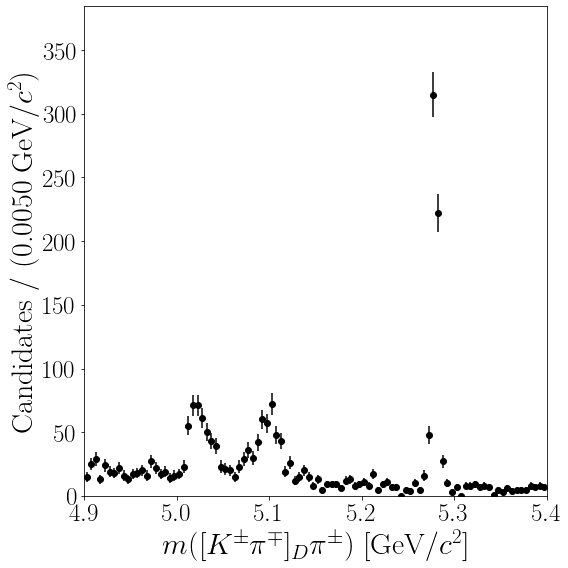

In [9]:
low = 4.9
high = 5.4
B_cut = np.logical_and(B["mass"] > low, B["mass"] < high)
B = B[B_cut]

plotting.errorbar_hist(B,"mass","B","$m([K^\pm \pi^\mp]_D \pi^\pm)$","GeV/$c^2$",low,high,100)